In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/amazon-fine-food-reviews/Reviews.csv
/kaggle/input/amazon-fine-food-reviews/database.sqlite
/kaggle/input/amazon-fine-food-reviews/hashes.txt


In [2]:
import pandas as pd
data=pd.read_csv("../input/amazon-fine-food-reviews/Reviews.csv",nrows=100000)


In [3]:
import numpy as np
import pandas as pd
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [4]:
data['Text'].head()

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [5]:
import tensorflow as tf
import os
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K


class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

In [6]:

data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na

In [7]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}



In [8]:
data['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

In [9]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()



In [10]:
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))

In [11]:
data['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [12]:
def summary_cleaner(text):
    newString = re.sub('"','', text)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString)
    newString = newString.lower()
    tokens=newString.split()
    newString=''
    for i in tokens:
        if len(i)>1:                                 
            newString=newString+i+' '  
    return newString

#Call the above function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(summary_cleaner(t))



In [13]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary
data['cleaned_summary'].replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

In [14]:
data['cleaned_summary'].iloc[:10]

0                         good quality dog food 
1                             not as advertised 
2                           delight says it all 
3                                cough medicine 
4                                   great taffy 
5                                    nice taffy 
6    great just as good as the expensive brands 
7                         wonderful tasty taffy 
8                                    yay barley 
9                              healthy dog food 
Name: cleaned_summary, dtype: object

In [15]:
data['cleaned_summary']=data['cleaned_summary'].apply(lambda x:'_start_'+x+"_end_")

In [16]:
for i in range(1,5):
    print(data['cleaned_text'][i])
    print(data['cleaned_summary'][i])

product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
_start_not as advertised _end_
confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
_start_delight says it all _end_
looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
_start_cough medicine _end_
great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
_start_great taffy _end_


In [17]:
import matplotlib.pyplot as plt
text_word_count=[]
summary_word_count=[]
for x in data['cleaned_summary']:
    summary_word_count.append(len(list(x.split())))
for x in data['cleaned_text']:
    text_word_count.append(len(list(x.split())))


In [18]:
length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

In [19]:
length_df.head()

,text,summary
0,23,5
1,18,4
2,39,5
3,17,3
4,13,3


In [20]:
#print({'text':text_word_count, 'summary':summary_word_count})

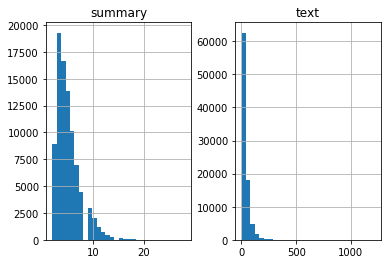

In [21]:
length_df.hist(bins = 30)
plt.show()

In [22]:
max_len_text=80 
max_len_summary=10

In [23]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['cleaned_text'],data['cleaned_summary'],test_size=0.1,random_state=0,shuffle=True) 

In [24]:
(x_tr)

3256                                                                                   item awesome chocolate flavor would recommend product anyone looking hot chocolate keurig machine uses cups great product
48476                                                                                                       work bar cup tea delicious held lunch later day great snack eat breakfast toss purse mid day munchie
78065                                                 product evil combines dark chocolate macadamia nuts known people call elder gods whatever yog sothoth open gates guarantee constant supply nuggets yuggoth
29079    nearby fresh easy grocery store small section premium soft drinks really good recently purchased pack izze sparkling blackberry assortment concentrated fruit juices dominated blackberry added carb...
15364    agree review beware plant pictured anything like purchased desert rose dad fell love one photo description amazon shipping weight says lbs mine ups lbs tot

In [25]:
x_tokenizer=Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [26]:
#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

In [27]:
x_tr[1]

[144,
 185,
 39,
 10,
 63,
 2213,
 612,
 543,
 56,
 6,
 102,
 33,
 295,
 1794,
 1563,
 1684,
 56,
 11513]

In [28]:
#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

In [29]:
x_tr[1]

array([  144,   185,    39,    10,    63,  2213,   612,   543,    56,
           6,   102,    33,   295,  1794,  1563,  1684,    56, 11513,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [30]:
x_voc_size   =  len(x_tokenizer.word_index) +1
print(x_voc_size)

51571


In [31]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1


In [32]:
print(y_voc_size)

14096


In [33]:
from tensorflow.keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = (LSTM(latent_dim,return_sequences=True,return_state=True,name='enc_lstm1')) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = Bidirectional(LSTM(latent_dim,return_sequences=True,return_state=True,name='enc_lstm2'),merge_mode='concat') 
encoder_output2, state_h2, state_c2,m,n = encoder_lstm2(encoder_output1) 
print(m.shape)
print(n.shape)
print(encoder_output2.shape)
print(state_h2.shape)
print(state_c2.shape)
#LSTM 3 
encoder_lstm3=Bidirectional(LSTM(latent_dim, return_state=True, return_sequences=True,name='enc_lstm3'),merge_mode='concat' )
encoder_outputs, state_h, state_c,b,v= encoder_lstm3(encoder_output2) 
print(b.shape)
print(v.shape)
print(encoder_outputs.shape)
print(state_h.shape)
print(state_c.shape)
# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,name='dec_lstm1') 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])#here dec  output is 
#an array of all the outputs together in one array of 2-dim each column representing an output of the sequence output.  

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

(None, 500)
(None, 500)
(None, 80, 1000)
(None, 500)
(None, 500)
(None, 500)
(None, 500)
(None, 80, 1000)
(None, 500)
(None, 500)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      25785500    input_1[0][0]                    
__________________________________________________________________________________________________
enc_lstm1 (LSTM)                [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0         

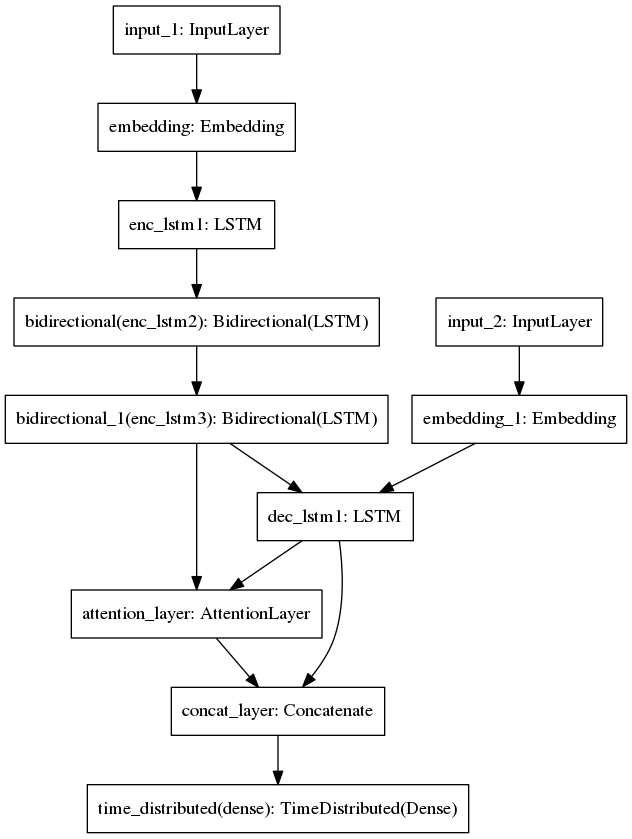

In [34]:
#return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.
#return_state: Boolean. Whether to return the last state in addition to the output. The returned elements of the states list are the hidden state and the cell state, respectively.
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model1.png')

In [35]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['acc'])

In [36]:
es = EarlyStopping(monitor='val_loss',mode='min', verbose=1)

In [37]:
#history=model.fit(x_tr, y_tr ,epochs=50,callbacks=[es],batch_size=512)


In [38]:
y_tr.shape

(79516, 10)

In [39]:
x_tr.shape

(79516, 80)

In [40]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=15,callbacks=[es],batch_size=512,validation_split=0.2)


Train on 63612 samples, validate on 15904 samples
Epoch 1/15
63612/63612 [==============================] - 177s 3ms/sample - loss: 3.2689 - acc: 0.5570 - val_loss: 2.9387 - val_acc: 0.5875
Epoch 2/15
63612/63612 [==============================] - 160s 3ms/sample - loss: 2.7573 - acc: 0.5983 - val_loss: 2.7154 - val_acc: 0.6034
Epoch 3/15
63612/63612 [==============================] - 159s 3ms/sample - loss: 2.5382 - acc: 0.6147 - val_loss: 2.5560 - val_acc: 0.6174
Epoch 4/15
63612/63612 [==============================] - 160s 3ms/sample - loss: 2.3802 - acc: 0.6271 - val_loss: 2.4676 - val_acc: 0.6239
Epoch 5/15
63612/63612 [==============================] - 160s 3ms/sample - loss: 2.2515 - acc: 0.6354 - val_loss: 2.4063 - val_acc: 0.6299
Epoch 6/15
63612/63612 [==============================] - 160s 3ms/sample - loss: 2.1393 - acc: 0.6428 - val_loss: 2.3823 - val_acc: 0.6331
Epoch 7/15
63612/63612 [==============================] - 160s 3ms/sample - loss: 2.0329 - acc: 0.6498 - val_l

In [41]:
#y_tr,y_tr[:,:-1]# both of these are not same #difference is the size number of columns
#np.shape(y_tr.reshape(y_tr.shape[0],y_tr.shape[1],1)) to predict one word at a time in the 


In [42]:
y_tr.shape,y_tr[:,:-1].shape

((79516, 10), (79516, 9))

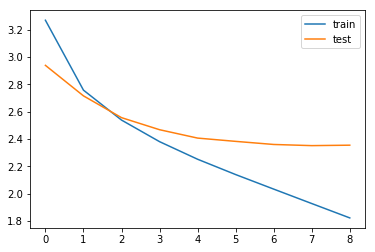

In [48]:
#pip uninstall tensorflow
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
#plt.xlim(0,2)
plt.legend() 
plt.show()

In [44]:
#pip install tensorflow==1.15

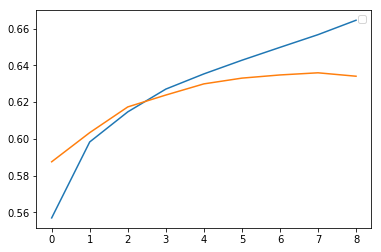

In [45]:
#from matplotlib import pyplot 
plt.plot(history.history['acc']) 
plt.plot(history.history['val_acc']) 
#plt.xlim(0,2)
plt.legend() 
plt.show()

In [46]:
reverse_target_word_index=y_tokenizer.index_word #index_word and word_index are two dictionaries in the class
reverse_source_word_index=x_tokenizer.index_word #initated for every object of the class in _init_ method.
target_word_index=y_tokenizer.word_index #i guess these are the two reversed dictionary in terms of values, key

In [49]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,),name='encoder_each_timestep_output')
decoder_state_input_c = Input(shape=(latent_dim,),name='encoder_each_timestep_hiddenstate')
decoder_hidden_state_input = Input(shape=(max_len_text,2*latent_dim),name='array_encoder_all_outputs')

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


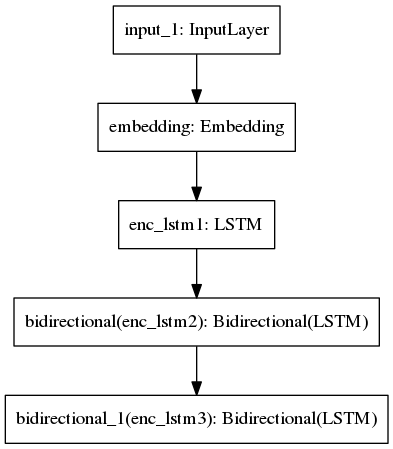

In [50]:
plot_model(encoder_model, to_file='encoder_model.png')


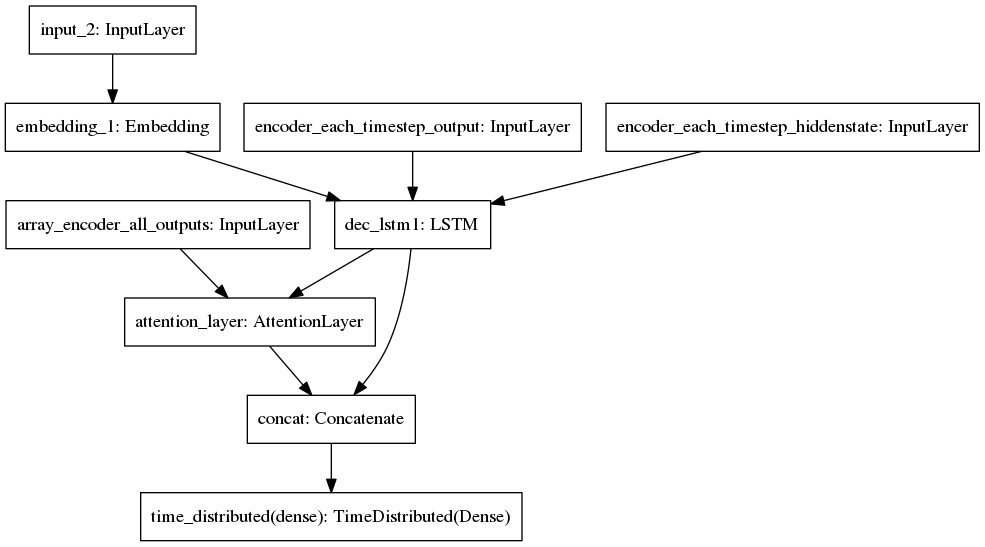

In [51]:
plot_model(decoder_model,to_file='decoder_model.png')


In [52]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
   # print(target_seq)

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']#target sequence going to the embedding layer
    #print(target_seq[0, 0])
    #print(target_word_index['end'])
    #print(reverse_target_word_index.items())
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])#encoder ouput is the decoder hidden state
        #print(output_tokens.shape)#(1,1,14096)
        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        #print(sampled_token_index)

        #print(sampled_token_index+1)
        #j+=1
        #if sampled_token_index !=0 :
        sampled_token = reverse_target_word_index[sampled_token_index]# +1 is done as dictionary starts from 1 and output_tokens start from 0
        #print(sampled_token)
        #print(reverse_target_word_index.items())#there is no key 0 in dictionary
        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token
            # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
             stop_condition = True
                

        # Update the target sequence (of length 1).
        #target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [53]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString


In [63]:
for i in range(int(len(x_val)/100)):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")

Review: ordered salmon thursday january received january salmon delicious wooden box nice design used store items future 
Original summary: alaska smokehouse smoked salmon 
Predicted summary:  great product


Review: drank cold could pleased coffee high quality arabica always notice coffee arabica robusta sweet without sweet mean cannot compare major bottled coffee brand reason alone keep fridge work offer people without looking like pushing calories along caffeine long time would stock highly sweetened coffee beverages fridge work noticed people stopped consuming happened around time lost interest level sweetness recommend drink prefer lower level sugar old school arabica coffee types 
Original summary: it was perfect little sweet without being too sweet 
Predicted summary:  love it


Review: variety granola one ranks top favorites crunch granola coconut main taste sweet overly eat snack craving something fills fast satisfies sugar cravings 
Original summary: great taste 
Predicted su

Predicted summary:  love it


Review: long time keurig user lifetime coffee drinker breakfast blend part plain cup coffee light smooth slight bitterness end still prefer donut shop light everyday coffee choice wanted try box green mountain probably purchase one house stopped said thats great cup coffee plain blah probably struggle finish box honestly 
Original summary: breakfast blend nothing special 
Predicted summary:  smooth and flavorful


Review: even though sealed individual packages nice seems like retain freshness sticks got like shoe leather little taste would purchase think flavor since vaccummed sealed freshness also sticks get hard 
Original summary: needs to freshness longer gets like shoe leather 
Predicted summary:  good but not great


Review: actually delivered two lbs bags box added bonus two spoons came box sure actually use overall favorite salt getting pound bags decided move lbs save money 
Original summary: good salt 
Predicted summary:  good stuff


Review: brew

Predicted summary:  good stuff


Review: hour energy like dream come true working spouse manager feet thirteen hours day gets extremely exhausting agreed receiving sample smiley online exchange opinions first line try impressed contained along folic acid small amount caffeine husband tried hour energy full day work hopes able stay awake watch baseball game surprized give hours energy hour energy also dietary supplement health education act fda 
Original summary: the energy booster with no sugar only calories 
Predicted summary:  works well for me


Review: happy recieved order cookies melted good product word advise buy products summer time melt 
Original summary: bahlsen cookies 
Predicted summary:  not as described


Review: agree reviewer think cereal marshmallows gross never liked teddy grahams much anyway 
Original summary: fake and gross 
Predicted summary:  not bad


Review: regular grocery store honey dark deep molasses flavor delicious anything would add honey like coffee 
Ori

Predicted summary:  love this tea


Review: pack time exactly ordered love kona blend thank goodness able find amazon since shortage get lasts 
Original summary: on time exactly as ordered 
Predicted summary:  great coffee


Review: nope let talk honey roasted peanuts cocktail peanuts cashews pistachios even mixed nuts crave high protein snack reach redskins planters spanish peanuts little red goobers delicious even better scarf handfuls waistline explode redskins perfect addition parties get togethers better way watch sporting event munch spanish name planters know going getting quality freshness hunkering wholesome salty snack look peanut sporting cane planters spanish peanuts nutty mikels esq 
Original summary: am nut job 
Predicted summary:  delicious and healthy


Review: one siberian eat anything including small horse fit dog mouth siberian princess licks licks full usually quickly happy dogs liked treats unfortunately diarrhea next day high back door pretty fast several times af

In [ ]:
x_val[0].reshape(1,max_len_text).shape


In [ ]:
x_val[0].shape

In [ ]:
x_val.shape

In [ ]:
# serialize model to JSON
model_json = model.to_json()
with open("summarization_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("summarization_model.h5")
print("Saved model to disk")

In [60]:
print("Review:",seq2text(x_val[1010]))
print("Original summary:",seq2summary(y_val[1010]))
print("Predicted summary:",decode_sequence(x_val[1010].reshape(1,max_len_text)))
print("\n")

Review: loving illy issimo coffee drink cappucino ounce cans expected like however tastes like mediocre slightly bitter espresso watered poured says sweetened beet sugar taste sweetness husband could even finish one offered husband could finish either love fresh brewed coffee become coffee snobs recently caring starbucks chain coffees like used expected brand measure expectations especially cappuccino fell miserably short 
Original summary: eh only okay for coffee not worth the price 
Predicted summary:  not bad




In [ ]:
# serialize model to JSON
model_json = decoder_model.to_json()
with open("decoder_model_f.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
decoder_model.save_weights("decoder_model_f.h5")
print("Saved model to disk")

In [ ]:
# serialize model to JSON
model_json = encoder_model.to_json()
with open("encoder_model_f.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
encoder_model.save_weights("encoder_model_f.h5")
print("Saved model to disk")

In [ ]:
tex='this is amazing but i hate it so what it is guess'